## Diabetes Prediction using Deep Learning

Problem Statement:
Consider yourself to be Matt, who is a Deep Learning Engineer at a prestigious company. Your company is working with the National Institute of Diabetes to find out what are the factors which lead up to a patient having diabetes.

Solution:
There could various factors that cause Diabetes, lets check out what are the import factors which would help us in predicting it. Based on the given problem statement,
1. The data set has label data therefore supervised learning models or Deep Learning model can be help us to predict
2. The response is a binary classification therefore we can use linear classifier models or ensemble classifier models

Lets try basic logistic Regression first and then try higher end models

### Import Libraries

I always like to import all libraries at helps me to gather my thoughts

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(
    action='ignore', module='matplotlib.figure', category=UserWarning,
    message=('This figure includes Axes that are not compatible with tight_layout, '
             'so results might be incorrect.')
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, LabelEncoder,PowerTransformer,QuantileTransformer
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from xgboost import XGBClassifier 
from keras.models import Sequential
from keras import layers,callbacks
from keras.layers import Dense

### Import Data

In [2]:
data = pd.read_csv('./../csv/diabetes.csv')
df = pd.DataFrame(data)
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

### Basic Information check

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
df[df.eq(0)==True].count()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [7]:
df.duplicated().sum()

0

#### Insights
1. There are 768 rows with 9 columns, out of which there are 8 features and 1 response
2. There are no categorical columns
3. No null or duplicate value found
4. Many columns are having 0 values, we will later fill with group means or use Linear Regression to predict it

### Statistical Description

In [8]:
df.iloc[:,:-1].describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


#### Insights
1. Skewed Columns
    - SkinThickness (Mean < Median) : 20.536458 < 23.0000 : Left Skewed
    - Insulin (Mean > Median) : 79.799479 > 30.5000 : Right Skewed
    - DiabetesPedigreeFunction (Mean > Median) :  0.471876 > 0.3725 : Right Skewed
    - Age (Mean > Median ) : 33.240885 > 29.0000  : Right Skewed    
2. High Variance Columns (Spread out):  Pregnancies, Glucose, SkinThickness, Insulin, Age

### Distribution Visualization

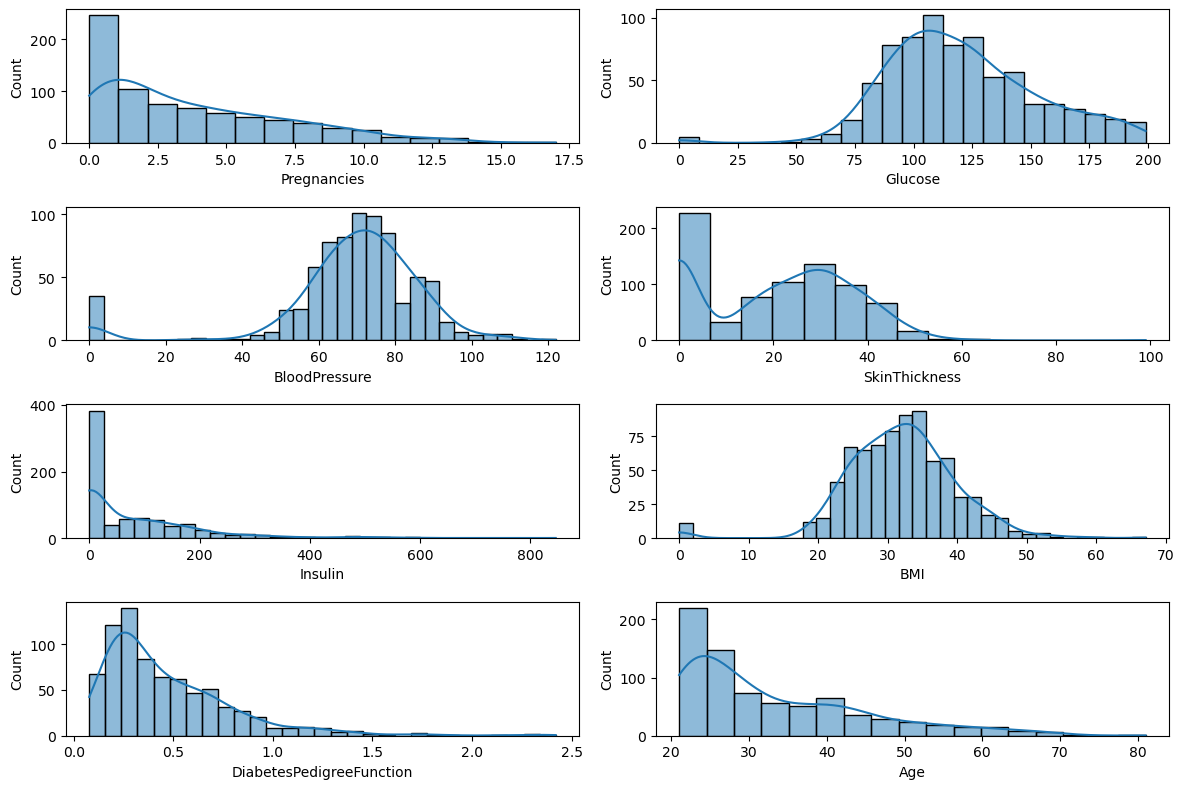

In [9]:
fig, ax= plt.subplots(nrows =4,ncols=2,figsize = (12,8))
j = 0
k = 0
for i,col in enumerate(df.columns[:-1]): 
    if i == 0:
        j = 0
        k = 0
    elif i%2 == 0:        
        j = j + 1
        k = 0
    else: 
        k = k + 1        
    fig.tight_layout()    
    ax[j,k].set_xlabel(col)
    sns.histplot(data=df[col],ax=ax[j,k],kde=True)     

#### Insights

The outliers % is very less therefore we can ignore

### Outlier Detection

In [10]:
for col in df.columns[:-1]:
    q1,q3 = df[col].quantile([.25,.75])    
    iqr = q3 - q1
    lf = q1 - (1.5 * iqr)
    uf = q3 + (1.5 * iqr)    
    lf_pct = (df[(df[col]< lf)][col].count()/df.shape[0])
    uf_pct = (df[(df[col]> uf)][col].count()/df.shape[0])
    print(f"The % of outliers in {col} = {lf_pct:.2%},{uf_pct:.2%}")

The % of outliers in Pregnancies = 0.00%,0.52%
The % of outliers in Glucose = 0.65%,0.00%
The % of outliers in BloodPressure = 4.95%,0.91%
The % of outliers in SkinThickness = 0.00%,0.13%
The % of outliers in Insulin = 0.00%,4.43%
The % of outliers in BMI = 1.43%,1.04%
The % of outliers in DiabetesPedigreeFunction = 0.00%,3.78%
The % of outliers in Age = 0.00%,1.17%


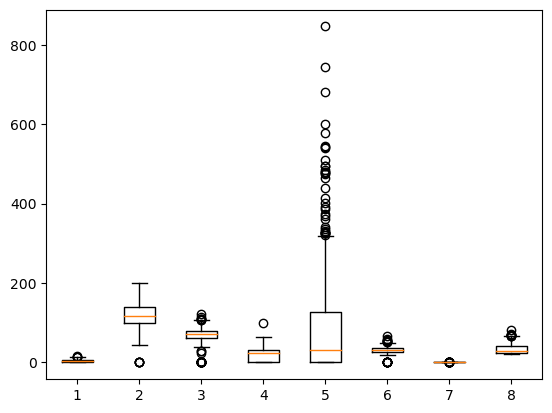

In [11]:
plt.boxplot(df[df.columns[:-1]])
plt.show()

### Class Balance

The class is slightly imbalanced, as the % is not more we can ignore

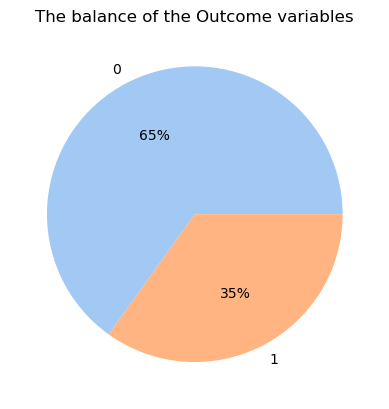

In [12]:
target = round((df['Outcome'].value_counts()/df.shape[0]) *100 ,2)
plt.title('The balance of the Outcome variables')
plt.pie(x=target,labels=target.index,colors=sns.color_palette('pastel'),autopct='%.0f%%')
plt.show()

### Exploratory Data Analysis

In [13]:
df_preg = df[['Pregnancies','Outcome']].groupby(by=['Pregnancies','Outcome']).agg({'Pregnancies':'count'})
df_preg = df_preg.rename(columns={'Pregnancies':'count'}).reset_index()
unusal_preg = (df_preg[df_preg['Pregnancies']>=6]['count'].sum()/df_preg['count'].sum() )  
print(f'Precentage of Unsual Pregnancies:{unusal_preg:.2%}')
df_preg[df_preg['Pregnancies']>=6]

Precentage of Unsual Pregnancies:28.52%


,Pregnancies,Outcome,count
12,6,0,34
13,6,1,16
14,7,0,20
15,7,1,25
16,8,0,16
17,8,1,22
18,9,0,10
19,9,1,18
20,10,0,14
21,10,1,10


In [14]:
df_preg_1 = df_preg[df_preg['Outcome']==1].iloc[0:5,:].sort_values(by='count',ascending=False)
df_preg_0 = df_preg[df_preg['Outcome']==0].iloc[0:5,:].sort_values(by='count',ascending=False)

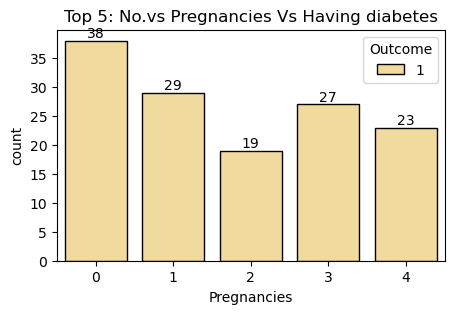

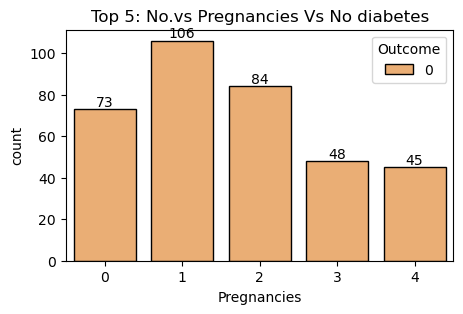

In [15]:
palette = ["#fee090"]
plt.figure(figsize=(5,3))
ax = sns.barplot(df_preg_1,x='Pregnancies',y='count',hue='Outcome',palette=palette,  edgecolor='black')
ax.bar_label(ax.containers[0]) 
ax.set_title('Top 5: No.vs Pregnancies Vs Having diabetes')
plt.show()
palette = ["#fdae61"]
plt.figure(figsize=(5,3))
ax=sns.barplot(df_preg_0,x='Pregnancies',y='count',hue='Outcome',palette=palette,  edgecolor='black')
ax.bar_label(ax.containers[0]) 
ax.set_title('Top 5: No.vs Pregnancies Vs No diabetes')
plt.show()

<Axes: xlabel='Pregnancies', ylabel='count'>

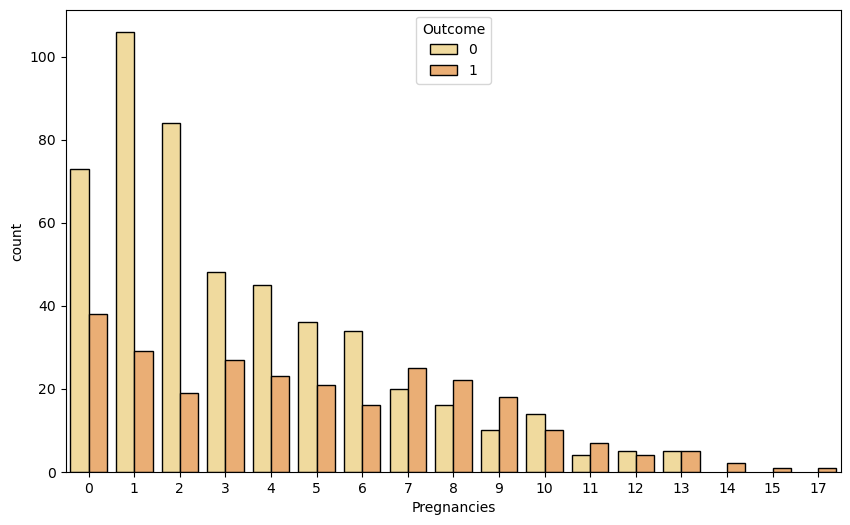

In [16]:
palette = ["#fee090", "#fdae61"]
plt.figure(figsize=(10,6))
sns.barplot(df_preg,x='Pregnancies',y='count',hue='Outcome',palette=palette,  edgecolor='black')

In [17]:
def annot_autopct(x):
    def my_autopct(pct):    
        total = sum(x)
        val = int(round(pct*total/100.0))
        return '{p:.0f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

In [18]:
df_glucose = df[['Glucose','Outcome']].groupby(by=['Outcome']).agg({'Glucose':'mean'})
df_glucose = df_glucose.rename(columns={'Glucose':'Avg'}).reset_index()
df_glucose

,Outcome,Avg
0,0,109.980000
1,1,141.257463


<Axes: ylabel='Avg'>

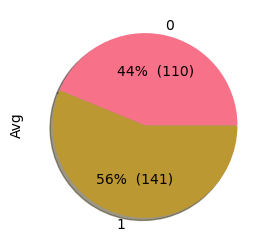

In [19]:
df_glucose.plot(kind='pie',x='Outcome',y='Avg' ,colors=sns.color_palette('husl'),labels=df_glucose['Outcome'],
               autopct = annot_autopct(df_glucose['Avg']),
               figsize=(4, 3),shadow=True,legend=False)

In [20]:
df_bp = df[['BloodPressure','Outcome']].groupby(by=['Outcome']).agg({'BloodPressure':'mean'})
df_bp = df_bp.rename(columns={'BloodPressure':'Avg'}).reset_index()
df_bp

,Outcome,Avg
0,0,68.184000
1,1,70.824627


<Axes: ylabel='Avg'>

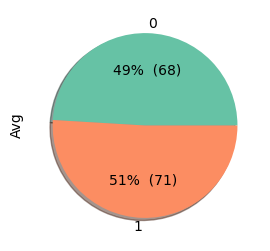

In [21]:
df_bp.plot(kind='pie',x='Outcome',y='Avg' ,colors=sns.color_palette('Set2'),labels=df_bp['Outcome'],
               autopct = annot_autopct(df_bp['Avg']),
               figsize=(4, 3),shadow=True,legend=False)

In [22]:
df_insulin = df[['Insulin','Outcome']].groupby(by=['Outcome']).agg({'Insulin':'mean'})
df_insulin = df_insulin.rename(columns={'Insulin':'Avg'}).reset_index()
df_insulin

,Outcome,Avg
0,0,68.792000
1,1,100.335821


<Axes: ylabel='Avg'>

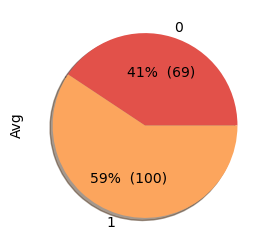

In [23]:
df_insulin.plot(kind='pie',x='Outcome',y='Avg' ,colors=sns.color_palette('Spectral'),labels=df_insulin['Outcome'],
               autopct = annot_autopct(df_insulin['Avg']),
               figsize=(4, 3),shadow=True,legend=False)

In [24]:
df_BMI = df[['BMI','Outcome']].groupby(by=['Outcome']).agg({'BMI':'mean'})
df_BMI = df_BMI.rename(columns={'BMI':'Avg'}).reset_index()
df_BMI

,Outcome,Avg
0,0,30.304200
1,1,35.142537


<Axes: ylabel='Avg'>

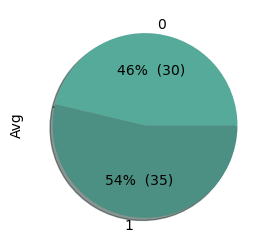

In [25]:
df_BMI.plot(kind='pie',x='Outcome',y='Avg' ,colors=sns.color_palette('dark:#5A9_r'),labels=df_BMI['Outcome'],
               autopct = annot_autopct(df_BMI['Avg']),
               figsize=(4, 3),shadow=True,legend=False)

In [26]:
df_dpf = df[['DiabetesPedigreeFunction','Outcome']].groupby(by=['Outcome']).agg({'DiabetesPedigreeFunction':'mean'})
df_dpf = df_dpf.rename(columns={'DiabetesPedigreeFunction':'Avg'}).reset_index()
df_dpf

,Outcome,Avg
0,0,0.429734
1,1,0.550500


<Axes: ylabel='Avg'>

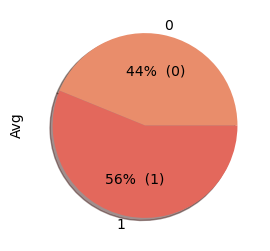

In [27]:
df_dpf.plot(kind='pie',x='Outcome',y='Avg' ,colors=sns.color_palette('flare'),labels=df_dpf['Outcome'],
               autopct = annot_autopct(df_dpf['Avg']),
               figsize=(4, 3),shadow=True,legend=False)

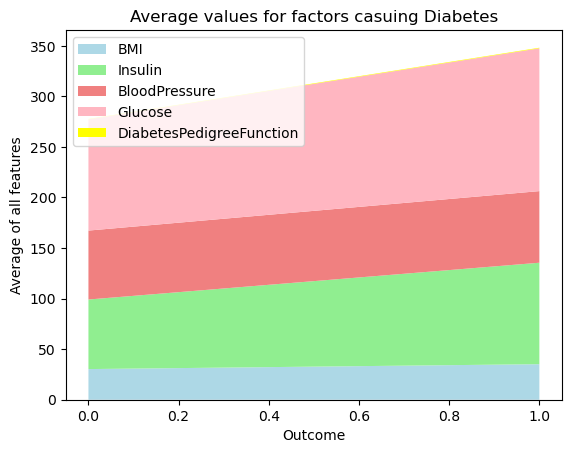

In [28]:
plt.stackplot(df_BMI['Outcome'], 
              df_BMI['Avg'], 
              df_insulin['Avg'], 
              df_bp['Avg'], 
              df_glucose['Avg'], 
              df_dpf['Avg'],
              labels=['BMI', 'Insulin', 'BloodPressure','Glucose','DiabetesPedigreeFunction'], 
              colors=['lightblue', 'lightgreen', 'lightcoral','lightpink','yellow',])

plt.legend(loc='upper left')
plt.xlabel('Outcome')
plt.ylabel('Average of all features')
plt.title('Average values for factors casuing Diabetes')

plt.show()

In [29]:
df['all_avg'] = df[['BloodPressure','Insulin','Glucose','DiabetesPedigreeFunction','BMI']].mean(axis=1)
df_high =df[(df['all_avg']< 50)&(df['Outcome']==1)][['Age','all_avg']].sort_values(by='Age',ascending=True)
df_high= df_high.groupby(by=['Age']).mean().reset_index()
df_low = df[(df['all_avg']> 100)&(df['Outcome']==0)][['Age','all_avg']].sort_values(by='Age',ascending=False)
df_low= df_low.groupby(by=['Age']).mean().reset_index()

In [30]:
init_notebook_mode(connected=True)
fig = px.line(df_high, x='Age', y='all_avg', title='Age wise people with diabetes though they low average',
              labels={'Age': 'Age', 'all_avg': 'Average of Factors'})

fig.update_layout(
    xaxis_title='Age',
    yaxis_title='Average of Factors',
    showlegend=False,
    width = 800,
    height = 500
)

In [31]:
init_notebook_mode(connected=True)
fig = px.line(df_low, x='Age', y='all_avg', title='Age wise people without diabetes though they high average',
              labels={'Age': 'Age', 'all_avg': 'Average of Factors'})

fig.update_layout(
    xaxis_title='Age',
    yaxis_title='Average of Factors',
    showlegend=False,
    width = 800,
    height = 500
)

<Axes: >

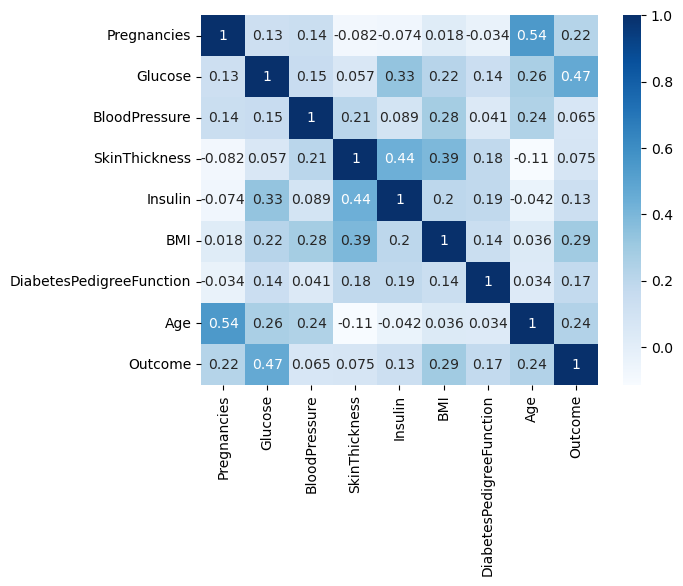

In [32]:
sns.heatmap(data=df[df.columns[:-1]].corr(),annot=True,cmap='Blues')

#### Insights
1. There are around 28.52% of more than 6 pregnancies, which in general considered unusual number
2. Intresting trends can be noticed for example 38 people of total 768 seemed to have diabetes who ever never pregnant
3. The highest people who have diabetes is those who were not pregnant. And those who did not have diabetest were people at  least pregnant once. Since we have not been given gender were are not sure if this apply to a bigger population
4. On examing all the average parameters, its obvious people with higher average are prone to diabetes
5. Exploring through area graph we can see that glucose plays an important role
6. There are few intresting trends when we compare age and average. we can see people in young age though their average levels are quite normal still prone to diabetes. And similarly people with high average and pretty old still dint have diabetes
7. Since are all are numeric variables, heatmap helps us to visualize correlation. There is is correlation for this dataset

There is no end to EDA we can still keep digging deeper, but for now let move to modelling

### Predict zero values using Linear Regression except for Pregnancy columns

In [33]:
lr_model = LinearRegression()
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    train_data = df.loc[df[col].eq(0)==False]
    test_data = df.loc[df[col].eq(0)==True][['DiabetesPedigreeFunction', 'Age', 'Outcome']].values
    x = df.loc[df[col].eq(0)==False][['DiabetesPedigreeFunction', 'Age', 'Outcome']].values
    y = df.loc[df[col].eq(0)==False][col].values
    
    lr_model.fit(x,y)
    pred = lr_model.predict(test_data)
    df[f'pred_{col}'] = df[col]
    df.loc[(df[col].eq(0)==True),f'pred_{col}'] =pred

### Normalilizing the KDE

In [34]:
qt = QuantileTransformer(n_quantiles=50, output_distribution='normal')
for col in ['Pregnancies', 'pred_SkinThickness','DiabetesPedigreeFunction', 'Age']:
    data = np.array(df[col]).reshape(-1, 1)   
    col_transformed = qt.fit_transform(data)
    df[f'{col}_transformed'] =col_transformed    

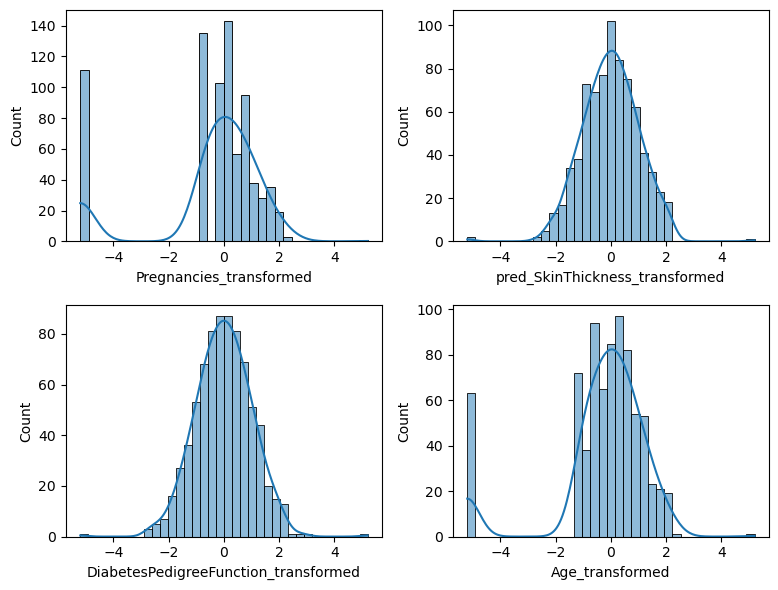

In [35]:
fig, ax= plt.subplots(nrows =2,ncols=2,figsize = (8,6))
j = 0
k = 0
for i,col in enumerate(['Pregnancies_transformed', 'pred_SkinThickness_transformed','DiabetesPedigreeFunction_transformed', 'Age_transformed']): 
    if i == 0:
        j = 0
        k = 0
    elif i%2 == 0:        
        j = j + 1
        k = 0
    else: 
        k = k + 1        
    fig.tight_layout()    
    ax[j,k].set_xlabel(col)
    sns.histplot(data=df[col],ax=ax[j,k],kde=True)     

###   Problem Statement 1
Build a sequential model using Keras on top of this Diabetes dataset to find out if the patient has diabetes or not, using Pregnancies, Glucose & BloodPressure as independent columns. 
1. This model should have 1 hidden layer with 8 nodes
2. Use Stochastic Gradient as the optimization algorithm
3. Fit the model, with number of epochs to be 100 and batch size to be 10

### Define x & y

In [36]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'all_avg',
       'pred_Glucose', 'pred_BloodPressure', 'pred_SkinThickness',
       'pred_Insulin', 'pred_BMI', 'Pregnancies_transformed',
       'pred_SkinThickness_transformed',
       'DiabetesPedigreeFunction_transformed', 'Age_transformed'],
      dtype='object')

In [37]:
x = df[['Pregnancies_transformed', 'pred_Glucose', 'pred_BloodPressure']]
y = df['Outcome']

In [38]:
x.shape,y.shape

((768, 3), (768,))

### Train, Test, Split Data

In [39]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [40]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((614, 3), (154, 3), (614,), (154,))

### Standardize Data using a sclar function

In [41]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

### Model Building - Problem Statement #2

### 1 : Logistic Regression

In [42]:
lg_model = LogisticRegression()
lg_model.fit(x_train_scaled,y_train)

LogisticRegression()

In [43]:
y_pred = lg_model.predict(x_test_scaled)
accuracy_score(y_test,y_pred)

0.7727272727272727

In [44]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced'],
    'tol': [1e-4, 1e-3, 1e-2]
}
grid_search = GridSearchCV(lg_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_scaled,y_train)
cv_results = pd.DataFrame(grid_search.cv_results_)

In [45]:
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation Accuracy: {grid_search.best_score_:.2%}')

Best parameters: {'C': 0.01, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}
Best cross-validation Accuracy: 74.59%


In [46]:
lg_model = LogisticRegression(C= 0.01, class_weight= None, max_iter = 100, penalty= 'l2', solver= 'saga', tol= 0.01)
lg_model.fit(x_train_scaled,y_train)

LogisticRegression(C=0.01, solver='saga', tol=0.01)

In [47]:
y_pred = lg_model.predict(x_test_scaled)
accuracy_score(y_test,y_pred)

0.7597402597402597

### 2 : Random Forest

In [48]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train_scaled,y_train)

RandomForestClassifier()

In [49]:
y_pred = rf_model.predict(x_test_scaled)
accuracy_score(y_test,y_pred)

0.7337662337662337

### 3 : XGBoost

In [50]:
xgb_model = XGBClassifier ()
xgb_model.fit(x_train_scaled,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [51]:
y_pred = xgb_model.predict(x_test_scaled)
accuracy_score(y_test,y_pred)

0.7337662337662337

### 4. ANN

In [52]:
ann_model = Sequential()

ann_model.add(Dense(32,activation='relu',input_shape = (x_train_scaled.shape[1],) ))
ann_model.add(Dense(8,activation='relu'))
ann_model.add(Dense(1,activation='sigmoid'))

ann_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401 (1.57 KB)

 Trainable params: 401 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
ann_model.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy'])

In [54]:
p_callback = callbacks.EarlyStopping( monitor='val_loss',mode='min',patience=10)

In [55]:
history = ann_model.fit(x_train_scaled,y_train,epochs=100,batch_size=10, callbacks=[p_callback])

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5175 - loss: 0.6950 
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.6893 - loss: 0.6418
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7052 - loss: 0.6191
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7129 - loss: 0.5913
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7555 - loss: 0.5644
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7350 - loss: 0.5585
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.7635 - loss: 0.5373
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7544 - loss: 0.5260
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7583 - loss: 0.5037
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7314 - loss: 0.5378
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7481 - loss: 0.5069
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - ac

In [56]:
loss,accuracy = ann_model.evaluate(x_test_scaled,y_test)
loss,accuracy

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7398 - loss: 0.5046  


(0.4981939196586609, 0.7597402334213257)

In [57]:
pred = ann_model.predict(x_test_scaled)
y_pred = (pred > 0.5).astype(int)
accuracy_score(y_test,y_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


0.7597402597402597

###   Problem Statement 2
Build another sequential model where ‘Outcome’ is the dependent variable and all other columns are predictors.
1. This model should have 3 hidden layers with 16 nodes in each layer
2. Use ‘adam’ as the optimization algorithm
3. Fit the model, with number of epochs to be 150 and batch size to be 10

### Define x & y

In [58]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'all_avg',
       'pred_Glucose', 'pred_BloodPressure', 'pred_SkinThickness',
       'pred_Insulin', 'pred_BMI', 'Pregnancies_transformed',
       'pred_SkinThickness_transformed',
       'DiabetesPedigreeFunction_transformed', 'Age_transformed'],
      dtype='object')

In [59]:
x = df[[ 'Pregnancies_transformed','pred_Glucose', 'pred_BloodPressure',
        'pred_SkinThickness_transformed', 'pred_Insulin',
       'pred_BMI', 'DiabetesPedigreeFunction_transformed', 'Age_transformed']]
y = df['Outcome']

In [60]:
x.shape,y.shape

((768, 8), (768,))

### Train, Test, Split Data

In [61]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [62]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((614, 8), (154, 8), (614,), (154,))

### Model Building - Problem Statement #2

### 1 : Logistic Regression

In [63]:
lg_model = LogisticRegression()
lg_model.fit(x_train_scaled,y_train)

LogisticRegression()

In [64]:
y_pred = lg_model.predict(x_test_scaled)
accuracy_score(y_test,y_pred)

0.7727272727272727

### 2 : Random Forest

In [65]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train_scaled,y_train)

RandomForestClassifier()

In [66]:
y_pred = rf_model.predict(x_test_scaled)
accuracy_score(y_test,y_pred)

0.7402597402597403

### 3 : XGBoost

In [67]:
xgb_model = XGBClassifier ()
xgb_model.fit(x_train_scaled,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [68]:
y_pred = xgb_model.predict(x_test_scaled)
accuracy_score(y_test,y_pred)

0.7337662337662337

### 4. ANN

In [69]:
ann_model = Sequential()

ann_model.add(Dense(32,activation='relu',input_shape = (x_train_scaled.shape[1],) ))
ann_model.add(Dense(16,activation='relu'))
ann_model.add(Dense(16,activation='relu'))
ann_model.add(Dense(16,activation='relu'))
ann_model.add(Dense(1,activation='sigmoid'))

ann_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
ann_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [71]:
p_callback = callbacks.EarlyStopping( monitor='val_loss',mode='min',patience=10)

In [72]:
history = ann_model.fit(x_train_scaled,y_train,epochs=150,batch_size=10, validation_split=0.2,callbacks=[p_callback])

Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6957 - loss: 0.6594 - val_accuracy: 0.7073 - val_loss: 0.5937
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7647 - loss: 0.5598 - val_accuracy: 0.7398 - val_loss: 0.5386
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7468 - loss: 0.5187 - val_accuracy: 0.7398 - val_loss: 0.5243
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7815 - loss: 0.4890 - val_accuracy: 0.7317 - val_loss: 0.5179
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7464 - loss: 0.5064 - val_accuracy: 0.7317 - val_loss: 0.5169
Epoch 6/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7569 - loss: 0.4717 - val_accuracy: 0.7236 - val_loss: 0.5105
Epoch 7/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7377 - loss: 0.4885 - val_accuracy: 0.7398 - val_loss: 0.5088
Epoch 8/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7473 - loss: 0.5185 - val_accuracy: 0.7642 - v

In [73]:
loss,accuracy = ann_model.evaluate(x_test_scaled,y_test)
loss,accuracy

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7515 - loss: 0.5179 


(0.5211756229400635, 0.7662337422370911)

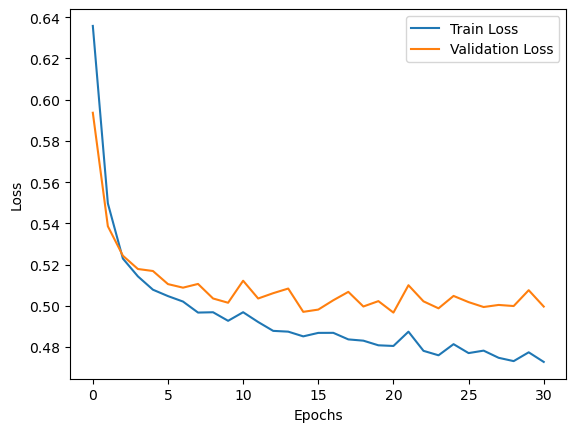

In [74]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

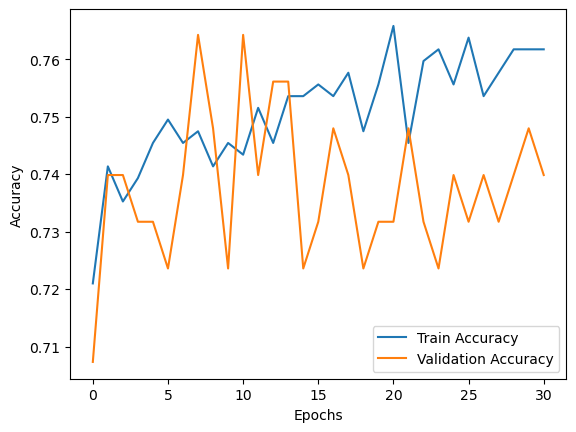

In [75]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [76]:
pred = ann_model.predict(x_test_scaled)
y_pred = (pred > 0.5).astype(int)
accuracy_score(y_test,y_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


0.7662337662337663

### Conclusion

Its a good learning today, I understood like Null values, 0 values could cause underfitting. Predicting it using linear regression gave me a better accuracy rather than just replacing it with Mean,Median or mode.

The Random forest model gave me the highest accuracy with 84%. As per per the given problem statement ANN with all columns and 3 hidden network gave around 81%.

### Thank you!!